# Machine learning on a tabular dataset

Distinguishing Higgs boson (signal) events from events without Higgs.

You have learned to do it with cuts - "linearly".

Now let's try to distinguish the events with a machine learning classifier to increase the signal/background ratio and make the analysis more sensitive.

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt

Follow the instructions here to install pytorch: https://pytorch.org/get-started/locally/

Pick your correct OS, I suggest to stick with the CPU version for now.

In [35]:
import pickle
import torch
import numpy as np
import tqdm
from torch.utils.data import TensorDataset, DataLoader
import sklearn
import sklearn.metrics

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time

In [36]:
import boost_histogram as bh
import mplhep

In [37]:
device = "cpu"

In [38]:
def plot_data_mc(var, bins, shapes=False):
    h1 = bh.Histogram(bins)
    h2 = bh.Histogram(bins)
    h3 = bh.Histogram(bins)
    h4 = bh.Histogram(bins)
    hdata = bh.Histogram(bins)

    h1.fill(data["TTbar"][var].values, weight=data["TTbar"]["weight"].values)
    h2.fill(data["DYJetsToLL"][var].values, weight=data["DYJetsToLL"]["weight"].values)

    for k in ["W1JetsToLNu", "W2JetsToLNu", "W3JetsToLNu"]:
        h3.fill(data[k][var].values, weight=data[k]["weight"].values)

    for k in ["GluGluToHToTauTau", "VBF_HToTauTau"]:
        h4.fill(data[k][var].values, weight=data[k]["weight"].values)

    for k in ["Run2012B_TauPlusX", "Run2012C_TauPlusX"]:
        hdata.fill(data[k][var].values)
      
    if shapes:
        mplhep.histplot(h1, label="ttbar", density=1)
        mplhep.histplot(h2, label="dy+jets", density=1)
        mplhep.histplot(h3, label="w+jets", density=1)
        mplhep.histplot(h4, label="Higgs", density=1)
        mplhep.histplot(hdata, histtype="errorbar", color="black", density=1)
    else:
        mplhep.histplot([h1, h2, h3, h4], stack=True, histtype="fill", label=["ttbar", "dy+jets", "w+jets", "Higgs"])
        mplhep.histplot(hdata, histtype="errorbar", color="black")
        plt.yscale("log")
    plt.legend(loc="best")
    
def evaluate_net(dataframe, net, keys):
    X = dataframe[keys].values
    y = net(torch.Tensor(X)).detach().numpy()
    return y

def prepare_feature_matrix(dataframe, feature_keys):
    X = torch.Tensor(dataframe[feature_keys].values)
    return X

def prepare_target_matrix(num_events, is_signal=True):
    if is_signal:
        y = np.ones((num_events, 1), dtype=np.float32)
    else:
        y = np.zeros((num_events, 1), dtype=np.float32)
    return torch.Tensor(y)

def prepare_datasets(
    keys,
    background_dataset_names=['DYJetsToLL', 'TTbar', 'W1JetsToLNu', 'W2JetsToLNu', 'W3JetsToLNu'],
    signal_dataset_names=['GluGluToHToTauTau', 'VBF_HToTauTau']):
    background_datasets = []
    for dataset_name in background_dataset_names:
        df = data[dataset_name]
        X = prepare_feature_matrix(df, keys)
        y = prepare_target_matrix(X.shape[0], is_signal=False)
        #get the sample weights according to the cross-section and MC sim statistics
        #add an ad-hoc weight factor of 100 for signal to balance out signal and background in the training
        w = 100.0*torch.Tensor(df["weight"].values)
        print(dataset_name, X.shape, y.shape)
        dataset = TensorDataset(X, y, w)
        background_datasets.append(dataset)

    signal_datasets = []
    for dataset_name in signal_dataset_names:
        df = data[dataset_name]
        X = prepare_feature_matrix(df, keys)
        y = prepare_target_matrix(X.shape[0], is_signal=True)
        w = torch.Tensor(df["weight"].values)
        print(dataset_name, X.shape, y.shape)
        dataset = TensorDataset(X, y, w)
        signal_datasets.append(dataset)

    all_datasets = torch.utils.data.ConcatDataset(background_datasets+signal_datasets)
    return all_datasets

def split_dataset(dataset):
    
    #generate a random permutation [0,1,2,...N-1] -> randomize order -> [...]
    random_order = np.random.permutation(len(dataset))
    
    #get the halfway point
    Nev_train = int(len(dataset)/2)
    
    #first half of the random indices is the training dataset
    train_indices = random_order[:Nev_train]
    
    #second half is the testing dataset
    test_indices = random_order[Nev_train:]
    
    #now generate new torch datasets with the indices
    train_ds = torch.utils.data.dataset.Subset(dataset, train_indices)
    test_ds = torch.utils.data.dataset.Subset(dataset, test_indices)
    
    return train_ds, test_ds

def train_model(net, train_loader, test_loader, num_epochs, lr=0.00001, device="cpu"):
    loss_train_vals = []
    loss_test_vals = []
    
    #binary cross entropy loss for supervised binary classification
    criterion = nn.BCELoss(reduction='none').to(device=device)
    
    #optimizer with the network parameters
    optimizer = optim.Adam(net.parameters(), lr=lr)
    
    net = net.to(device=device)

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        t0 = time.time()
        loss_train = []
        for i, batch_data in tqdm.tqdm(enumerate(train_loader, 0), total=len(train_loader), ncols=100):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels, sample_weights = batch_data

            inputs = inputs.to(device=device)
            labels = labels.to(device=device)
            sample_weights = sample_weights.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)

            loss = criterion(outputs, labels)
            
            #weight each in the loss
            loss = loss*sample_weights
            #compute the weighted mean
            loss = torch.sum(loss)/torch.sum(sample_weights)

            loss.backward()
            optimizer.step()

            # print statistics
            loss_train.append(loss.item())

        loss_train = np.mean(loss_train)
        loss_train_vals.append(loss_train)

        loss_test = []
        with torch.no_grad():
            for i, batch_data in tqdm.tqdm(enumerate(test_loader, 0), total=len(test_loader), ncols=100):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels, sample_weights = batch_data

                inputs = inputs.to(device=device)
                labels = labels.to(device=device)
                sample_weights = sample_weights.to(device)

                # forward
                outputs = net(inputs)

                loss = criterion(outputs, labels)
                loss = loss*sample_weights
                loss = torch.sum(loss)/torch.sum(sample_weights)

                # print statistics
                loss_test.append(loss.item())
        loss_test = np.mean(loss_test)
        loss_test_vals.append(loss_test)
        
        t1 = time.time()
        print("Epoch {}: {:.6f}/{:.6f}, t={:.2f}".format(epoch, loss_train, loss_test, t1-t0))
    return loss_train_vals, loss_test_vals


def plot_loss(loss_train_vals, loss_test_vals):
    fig, ax = plt.subplots(2,1, figsize=(10,5))
    plt.sca(ax[0])
    plt.plot(loss_train_vals[1:])
    plt.xlabel("epoch")
    plt.title("Train")
    plt.sca(ax[1])
    plt.plot(loss_test_vals[1:])
    plt.title("Test")
    plt.xlabel("epoch")
    plt.tight_layout()

def sum_weights(dataset_names):
    sumw = 0
    for ds in dataset_names:
        sumw += np.sum(data[ds]["weight"])
    return sumw

def sum_weights_varcut(dataset_names, var, cut):
    sumw = 0
    for ds in dataset_names:
        sumw += np.sum(data[ds][data[ds][var]>cut]["weight"])
    return sumw

def sumw_ratio(dataset_names, var, cut):
    return sum_weights_varcut(dataset_names, var, cut) / sum_weights(dataset_names)

def roc_curve(var):
    datasets_mc = ['GluGluToHToTauTau', 'VBF_HToTauTau', 'DYJetsToLL', 'TTbar', 'W1JetsToLNu', 'W2JetsToLNu', 'W3JetsToLNu']
    
    #compute the weighted roc curve according to the sample weights
    fpr, tpr, thresh = sklearn.metrics.roc_curve(
        np.concatenate([data[dn]["is_signal"] for dn in datasets_mc]),
        np.concatenate([data[dn][var] for dn in datasets_mc]),
        sample_weight=np.concatenate([data[dn]["weight"] for dn in datasets_mc]),
    )
    
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr)
    
    #get the index in the arrays where FPR~0.2
    idx_fpr_0p2 = np.searchsorted(fpr, 0.2)
    
    #find the corresponding TPR
    tpr_wp = tpr[idx_fpr_0p2]
    
    #find the corresponding value in the MVA output
    thresh_val = thresh[idx_fpr_0p2]
    
    #compute the fraction of weights that pass the threshold
    sumw_tt = sumw_ratio(["TTbar"], var, thresh_val)
    sumw_dy = sumw_ratio(["DYJetsToLL"], var, thresh_val)
    sumw_wjets = sumw_ratio(["W1JetsToLNu", "W2JetsToLNu", "W3JetsToLNu"], var, thresh_val)
    sumw_higgs = sumw_ratio(["VBF_HToTauTau", "GluGluToHToTauTau"], var, thresh_val)
    
    plt.axvline(0.2, color="black", ls="--")
    
    auc = sklearn.metrics.auc(fpr, tpr)
    plt.plot([0,1],[0,1], color="black", lw=0.5, ls="--")
    plt.title("AUC={:.2f}, TPR(FPR=0.2)={:.2f}\nttbar={:.2f}, dy={:.2f}, w={:.2f}, h={:.2f}".format(auc, tpr_wp, sumw_tt, sumw_dy, sumw_wjets, sumw_higgs))
    plt.ylabel("Fraction of signal weights")
    plt.xlabel("Fraction of background weights")
    #plt.xlim(0,0.2)
    #plt.ylim(0,0.2)
    
    return thresh_val

class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
                
        self.lin1 = nn.Linear(input_dim, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, hidden_dim)
        self.lin3 = nn.Linear(hidden_dim, 1)
        
        self.act = torch.nn.ELU()
        
    def forward(self, x):
                
        x = self.act(self.lin1(x))
        x = self.act(self.lin2(x))
        x = self.lin3(x)

        x = torch.sigmoid(x)
        return x

In [39]:
data = pickle.load(open("htautau.pkl", "rb"))
for dataset_name in data.keys():
    data[dataset_name]["is_signal"] = 1.0 if dataset_name in ["GluGluToHToTauTau", "VBF_HToTauTau"] else 0.0

In [40]:
training_features_few = ["mt_1", "mt_2"]
net1 = Net(len(training_features_few))

TTbar torch.Size([36866, 2]) torch.Size([36866, 1])
GluGluToHToTauTau torch.Size([8085, 2]) torch.Size([8085, 1])


100%|████████████████████████████████████████████████████████████| 176/176 [00:00<00:00, 435.53it/s]


Epoch 0: 40.282077/41.638133, t=1.11


100%|████████████████████████████████████████████████████████████| 176/176 [00:00<00:00, 365.03it/s]


Epoch 1: 38.672527/40.202310, t=1.15


100%|████████████████████████████████████████████████████████████| 176/176 [00:00<00:00, 448.26it/s]


Epoch 2: 38.325305/39.977626, t=1.06


100%|████████████████████████████████████████████████████████████| 176/176 [00:00<00:00, 412.15it/s]


Epoch 3: 38.101636/39.911683, t=1.07


100%|████████████████████████████████████████████████████████████| 176/176 [00:00<00:00, 358.05it/s]


Epoch 4: 37.867401/39.582258, t=1.18


100%|████████████████████████████████████████████████████████████| 176/176 [00:00<00:00, 339.57it/s]


Epoch 5: 37.669210/39.400657, t=1.17


100%|████████████████████████████████████████████████████████████| 176/176 [00:00<00:00, 424.45it/s]


Epoch 6: 37.527581/39.353849, t=1.12


100%|████████████████████████████████████████████████████████████| 176/176 [00:00<00:00, 405.99it/s]


Epoch 7: 37.374100/39.088692, t=1.11


100%|████████████████████████████████████████████████████████████| 176/176 [00:00<00:00, 421.96it/s]


Epoch 8: 37.261370/39.241938, t=1.09


100%|████████████████████████████████████████████████████████████| 176/176 [00:00<00:00, 416.02it/s]


Epoch 9: 37.128939/39.144697, t=1.10


100%|████████████████████████████████████████████████████████████| 176/176 [00:00<00:00, 355.40it/s]


Epoch 10: 37.048158/38.837456, t=1.16


100%|████████████████████████████████████████████████████████████| 176/176 [00:00<00:00, 440.17it/s]


Epoch 11: 37.051955/39.215200, t=1.06


100%|████████████████████████████████████████████████████████████| 176/176 [00:00<00:00, 429.66it/s]


Epoch 12: 36.875261/38.787408, t=1.07


100%|████████████████████████████████████████████████████████████| 176/176 [00:00<00:00, 386.08it/s]


Epoch 13: 36.818073/38.748652, t=1.20


100%|████████████████████████████████████████████████████████████| 176/176 [00:00<00:00, 341.53it/s]


Epoch 14: 36.811954/38.707210, t=1.32


100%|████████████████████████████████████████████████████████████| 176/176 [00:00<00:00, 363.16it/s]


Epoch 15: 36.801257/38.727970, t=1.24


100%|████████████████████████████████████████████████████████████| 176/176 [00:00<00:00, 353.02it/s]


Epoch 16: 36.760366/38.566408, t=1.20


100%|████████████████████████████████████████████████████████████| 176/176 [00:00<00:00, 438.54it/s]


Epoch 17: 36.677637/38.583028, t=1.18


100%|████████████████████████████████████████████████████████████| 176/176 [00:00<00:00, 409.40it/s]


Epoch 18: 36.701096/38.976721, t=1.17


100%|████████████████████████████████████████████████████████████| 176/176 [00:00<00:00, 382.31it/s]


Epoch 19: 36.770530/39.608266, t=1.20


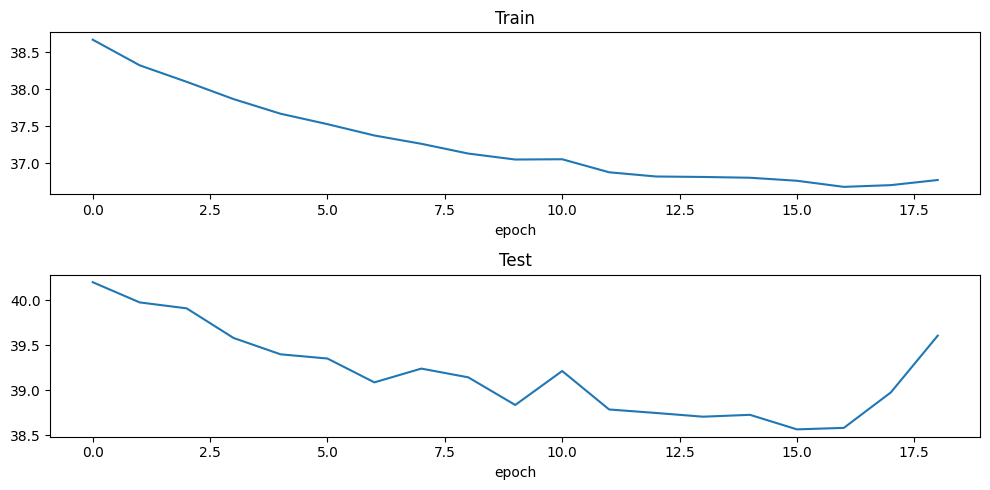

In [41]:
all_datasets = prepare_datasets(
    training_features_few,
    background_dataset_names=["TTbar"], signal_dataset_names=["GluGluToHToTauTau"]
)
train_ds, test_ds = split_dataset(all_datasets)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=True)

loss_train_vals, loss_test_vals = train_model(net1, train_loader, test_loader, 20, 1e-4, device)

plot_loss(loss_train_vals, loss_test_vals)

In [42]:
net1 = net1.to(device="cpu")

In [43]:
for dataset_name in data.keys():
    data[dataset_name]["mva_1_trained"] = evaluate_net(data[dataset_name], net1, training_features_few)

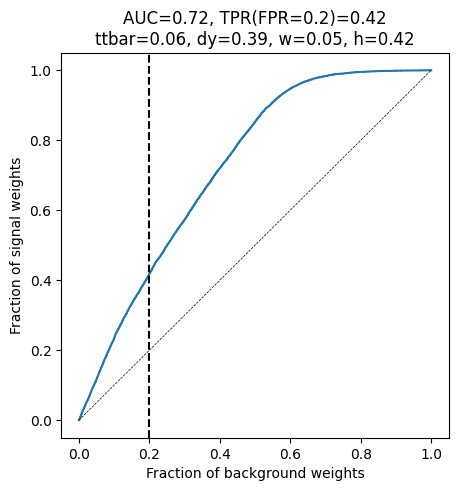

In [44]:
thresh_mva_1 = roc_curve("mva_1_trained")

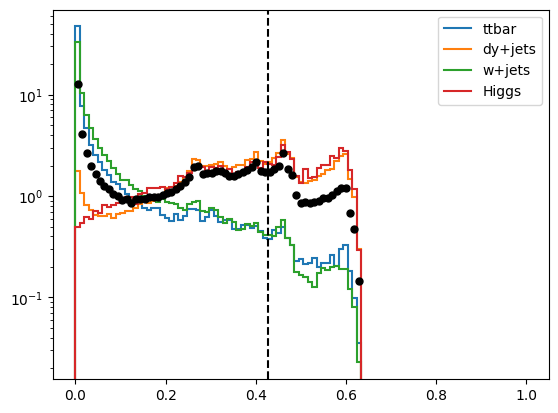

In [45]:
plot_data_mc("mva_1_trained", bh.axis.Regular(101,0.0,1.0), shapes=True)
plt.axvline(thresh_mva_1, color="black", ls="--")
plt.yscale('log')

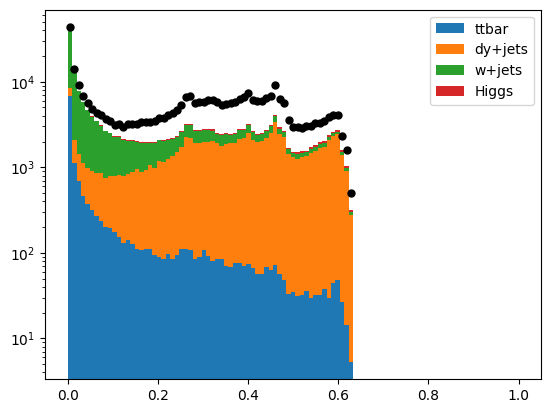

In [46]:
plot_data_mc("mva_1_trained", bh.axis.Regular(101,0.0,1.0))

## Exercise 1: add additional simulated datasets for training

To improve the generalization performance of the model, add the other datasets (both signal and background) with the appropriate weights.

DYJetsToLL torch.Size([70123, 2]) torch.Size([70123, 1])
TTbar torch.Size([36866, 2]) torch.Size([36866, 1])
W1JetsToLNu torch.Size([23970, 2]) torch.Size([23970, 1])
W2JetsToLNu torch.Size([42396, 2]) torch.Size([42396, 1])
W3JetsToLNu torch.Size([23954, 2]) torch.Size([23954, 1])
GluGluToHToTauTau torch.Size([8085, 2]) torch.Size([8085, 1])
VBF_HToTauTau torch.Size([10492, 2]) torch.Size([10492, 1])


100%|████████████████████████████████████████████████████████████| 844/844 [00:02<00:00, 408.11it/s]


Epoch 0: 32.905501/32.700180, t=5.40


100%|████████████████████████████████████████████████████████████| 844/844 [00:02<00:00, 385.42it/s]


Epoch 1: 32.327726/32.330330, t=5.50


100%|████████████████████████████████████████████████████████████| 844/844 [00:01<00:00, 451.10it/s]


Epoch 2: 32.105940/32.074839, t=4.76


100%|████████████████████████████████████████████████████████████| 844/844 [00:01<00:00, 426.73it/s]


Epoch 3: 31.938121/31.927098, t=4.97


100%|████████████████████████████████████████████████████████████| 844/844 [00:02<00:00, 407.83it/s]


Epoch 4: 31.876959/31.967416, t=4.91


100%|████████████████████████████████████████████████████████████| 844/844 [00:01<00:00, 440.32it/s]


Epoch 5: 31.802850/31.839518, t=4.94


100%|████████████████████████████████████████████████████████████| 844/844 [00:01<00:00, 428.12it/s]


Epoch 6: 31.753364/31.896730, t=4.67


100%|████████████████████████████████████████████████████████████| 844/844 [00:01<00:00, 476.41it/s]


Epoch 7: 31.706154/31.740037, t=4.64


100%|████████████████████████████████████████████████████████████| 844/844 [00:01<00:00, 489.36it/s]


Epoch 8: 31.716961/31.844140, t=4.66


100%|████████████████████████████████████████████████████████████| 844/844 [00:01<00:00, 466.97it/s]


Epoch 9: 31.681905/31.666250, t=4.84


100%|████████████████████████████████████████████████████████████| 844/844 [00:01<00:00, 431.57it/s]


Epoch 10: 31.627895/31.651401, t=4.81


100%|████████████████████████████████████████████████████████████| 844/844 [00:02<00:00, 385.60it/s]


Epoch 11: 31.615853/31.953043, t=5.17


100%|████████████████████████████████████████████████████████████| 844/844 [00:02<00:00, 296.50it/s]


Epoch 12: 31.635202/31.761954, t=7.60


100%|████████████████████████████████████████████████████████████| 844/844 [00:02<00:00, 327.40it/s]


Epoch 13: 31.605458/31.669278, t=11.14


100%|████████████████████████████████████████████████████████████| 844/844 [00:02<00:00, 329.26it/s]


Epoch 14: 31.571040/31.771418, t=6.83


100%|████████████████████████████████████████████████████████████| 844/844 [00:02<00:00, 310.30it/s]


Epoch 15: 31.549501/31.593957, t=6.79


100%|████████████████████████████████████████████████████████████| 844/844 [00:02<00:00, 330.15it/s]


Epoch 16: 31.564824/31.652139, t=6.64


100%|████████████████████████████████████████████████████████████| 844/844 [00:02<00:00, 362.95it/s]


Epoch 17: 31.531352/31.862919, t=6.35


100%|████████████████████████████████████████████████████████████| 844/844 [00:02<00:00, 339.50it/s]


Epoch 18: 31.525051/31.680078, t=6.52


100%|████████████████████████████████████████████████████████████| 844/844 [00:02<00:00, 339.51it/s]


Epoch 19: 31.526393/31.969358, t=6.35


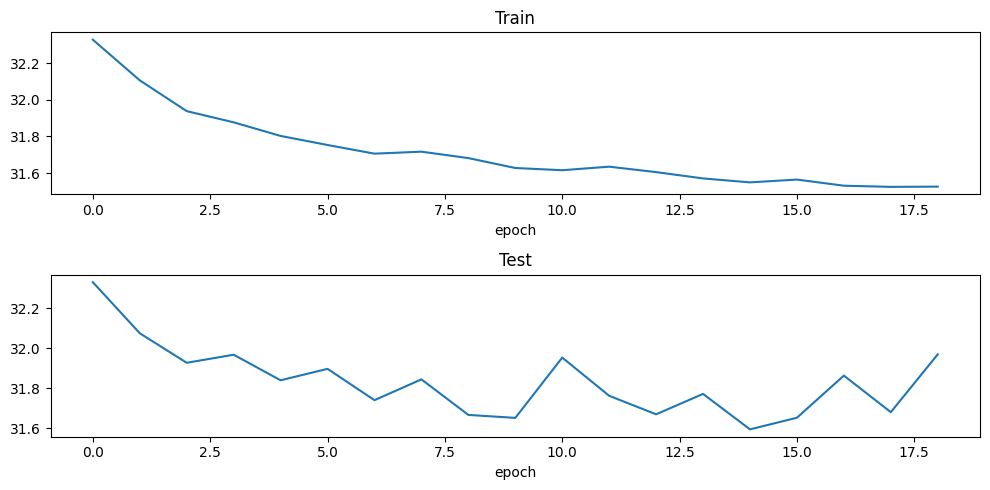

In [47]:
net2 = Net(len(training_features_few))

all_datasets = prepare_datasets(training_features_few)
train_ds, test_ds = split_dataset(all_datasets)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=True)

loss_train_vals, loss_test_vals = train_model(net2, train_loader, test_loader, 20, 1e-4, device)

plot_loss(loss_train_vals, loss_test_vals)

In [48]:
net2 = net2.to(device="cpu")
for dataset_name in data.keys():
    data[dataset_name]["mva_2_trained"] = evaluate_net(data[dataset_name], net2, training_features_few)

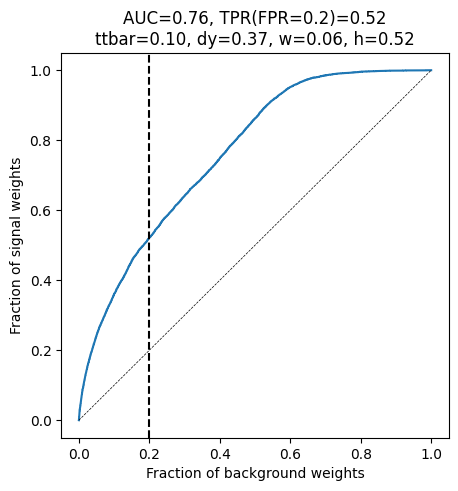

In [49]:
thresh_mva_2 = roc_curve("mva_2_trained")

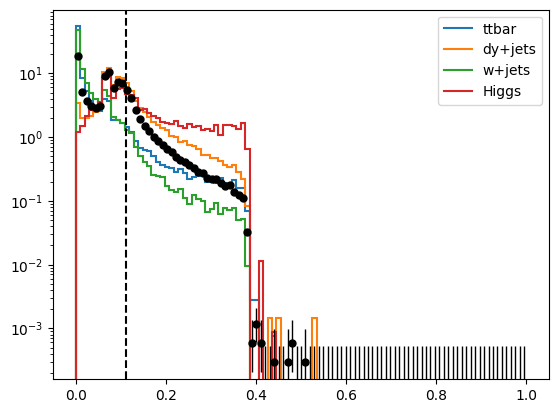

In [50]:
plot_data_mc("mva_2_trained", bh.axis.Regular(101,0.0,1.0), shapes=True)
plt.yscale("log")
plt.axvline(thresh_mva_2, color='black', ls="--")

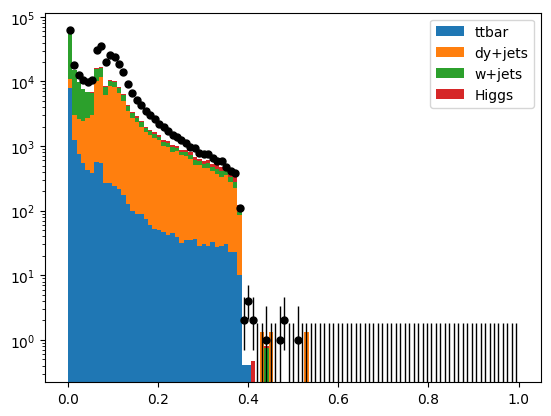

In [51]:
plot_data_mc("mva_2_trained", bh.axis.Regular(101,0.0,1.0))

## Exercise 3: add additional variables to the classifier



Add additional input variables / observed features to the classifier. Compare the performance to the two-variable (mt1, mt2) classifier.

DYJetsToLL torch.Size([70123, 31]) torch.Size([70123, 1])
TTbar torch.Size([36866, 31]) torch.Size([36866, 1])
W1JetsToLNu torch.Size([23970, 31]) torch.Size([23970, 1])
W2JetsToLNu torch.Size([42396, 31]) torch.Size([42396, 1])
W3JetsToLNu torch.Size([23954, 31]) torch.Size([23954, 1])
GluGluToHToTauTau torch.Size([8085, 31]) torch.Size([8085, 1])
VBF_HToTauTau torch.Size([10492, 31]) torch.Size([10492, 1])


100%|████████████████████████████████████████████████████████████| 844/844 [00:02<00:00, 352.50it/s]


Epoch 0: 434.475218/382.057282, t=6.09


100%|████████████████████████████████████████████████████████████| 844/844 [00:03<00:00, 264.44it/s]


Epoch 1: 321.340460/282.412972, t=8.11


100%|████████████████████████████████████████████████████████████| 844/844 [00:02<00:00, 305.49it/s]


Epoch 2: 188.424554/28.176977, t=7.28


100%|████████████████████████████████████████████████████████████| 844/844 [00:02<00:00, 303.16it/s]


Epoch 3: 27.698660/27.463623, t=7.00


100%|████████████████████████████████████████████████████████████| 844/844 [00:02<00:00, 311.50it/s]


Epoch 4: 27.151794/27.791700, t=6.97


100%|████████████████████████████████████████████████████████████| 844/844 [00:02<00:00, 316.80it/s]


Epoch 5: 26.733704/26.788794, t=6.97


100%|████████████████████████████████████████████████████████████| 844/844 [00:02<00:00, 300.19it/s]


Epoch 6: 26.397160/27.111318, t=7.12


100%|████████████████████████████████████████████████████████████| 844/844 [00:02<00:00, 326.68it/s]


Epoch 7: 26.182671/26.337440, t=6.95


100%|████████████████████████████████████████████████████████████| 844/844 [00:02<00:00, 287.12it/s]


Epoch 8: 26.028464/25.888379, t=7.20


100%|████████████████████████████████████████████████████████████| 844/844 [00:02<00:00, 290.91it/s]


Epoch 9: 25.745280/25.682459, t=7.30


100%|████████████████████████████████████████████████████████████| 844/844 [00:03<00:00, 226.06it/s]


Epoch 10: 25.684543/26.281836, t=8.27


100%|████████████████████████████████████████████████████████████| 844/844 [00:02<00:00, 283.95it/s]


Epoch 11: 25.490465/25.157021, t=7.42


100%|████████████████████████████████████████████████████████████| 844/844 [00:02<00:00, 287.16it/s]


Epoch 12: 25.260897/25.058546, t=7.37


100%|████████████████████████████████████████████████████████████| 844/844 [00:02<00:00, 301.65it/s]


Epoch 13: 25.170511/25.009492, t=7.04


100%|████████████████████████████████████████████████████████████| 844/844 [00:02<00:00, 290.35it/s]


Epoch 14: 25.046606/24.760515, t=7.20


100%|████████████████████████████████████████████████████████████| 844/844 [00:02<00:00, 286.21it/s]


Epoch 15: 24.860445/25.123752, t=7.51


100%|████████████████████████████████████████████████████████████| 844/844 [00:02<00:00, 296.45it/s]


Epoch 16: 24.766180/24.782299, t=7.21


100%|████████████████████████████████████████████████████████████| 844/844 [00:02<00:00, 285.00it/s]


Epoch 17: 24.753496/24.864223, t=7.43


100%|████████████████████████████████████████████████████████████| 844/844 [00:02<00:00, 287.47it/s]


Epoch 18: 24.599344/24.876367, t=7.45


100%|████████████████████████████████████████████████████████████| 844/844 [00:02<00:00, 294.84it/s]


Epoch 19: 24.534747/25.202098, t=7.32


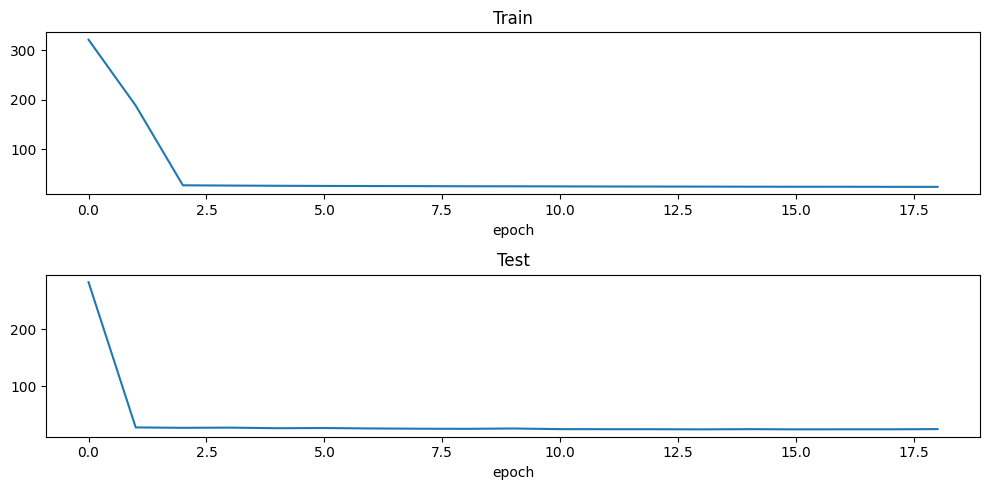

In [52]:
training_features_all = [
    "njets", "npv",
    "pt_1", "eta_1", "phi_1", "m_1", "iso_1", "q_1",
    "mt_1",
    "pt_2", "eta_2", "phi_2", "m_2", "iso_2", "q_2",
    "mt_2",
    "dm_2",
    "jpt_1", "jeta_1", "jphi_1", "jm_1", "jbtag_1",
    "jpt_2", "jeta_2", "jphi_2", "jm_2", "jbtag_2",
    "pt_met", "phi_met", "m_vis", "pt_vis",
]

net3 = Net(len(training_features_all))

all_datasets = prepare_datasets(training_features_all)
train_ds, test_ds = split_dataset(all_datasets)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=True)

loss_train_vals, loss_test_vals = train_model(net3, train_loader, test_loader, 20, 5e-5, device)

plot_loss(loss_train_vals, loss_test_vals)

In [53]:
net3 = net3.to(device="cpu")
for dataset_name in data.keys():
    data[dataset_name]["mva_3_trained"] = evaluate_net(data[dataset_name], net3, training_features_all)

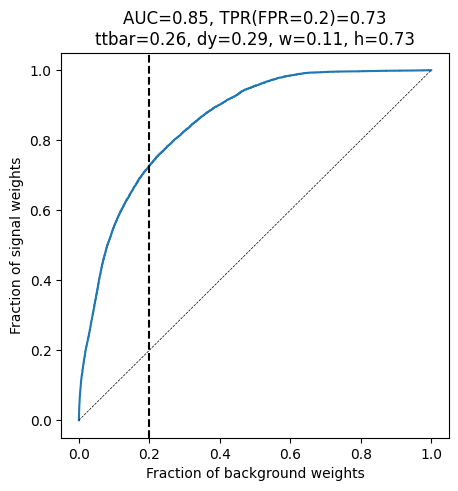

In [54]:
thresh_mva_3 = roc_curve("mva_3_trained")

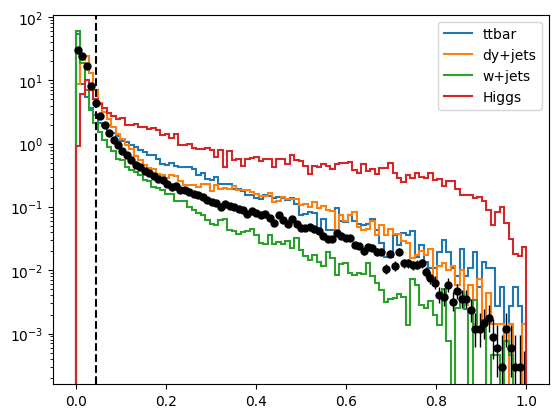

In [55]:
plot_data_mc("mva_3_trained", bh.axis.Regular(101,0.0,1.0), shapes=True)
plt.yscale("log")
plt.axvline(thresh_mva_3, color="black", ls="--")

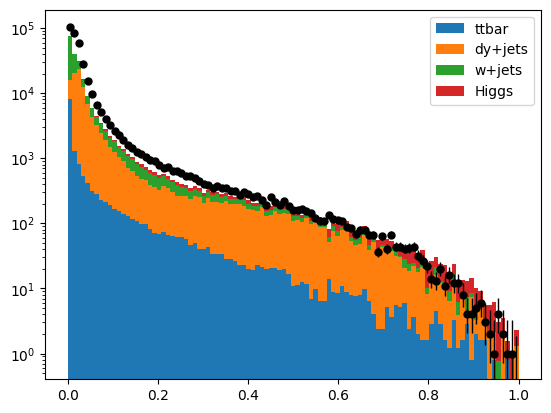

In [56]:
plot_data_mc("mva_3_trained", bh.axis.Regular(101,0.0,1.0))

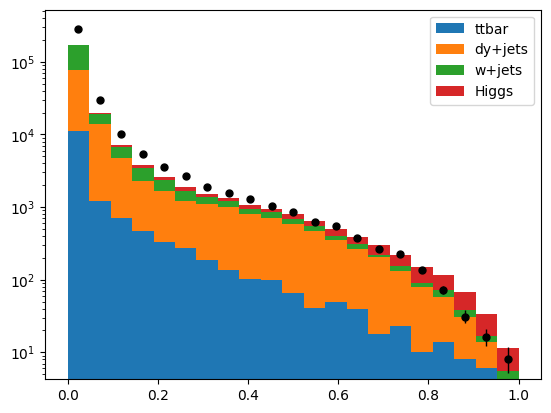

In [57]:
plot_data_mc("mva_3_trained", bh.axis.Regular(21,0.0,1.0))

# Exercise 4: train with a bigger net, observe overtraining

In [58]:
from sklearn import preprocessing

DYJetsToLL torch.Size([70123, 31]) torch.Size([70123, 1])
TTbar torch.Size([36866, 31]) torch.Size([36866, 1])
W1JetsToLNu torch.Size([23970, 31]) torch.Size([23970, 1])
W2JetsToLNu torch.Size([42396, 31]) torch.Size([42396, 1])
W3JetsToLNu torch.Size([23954, 31]) torch.Size([23954, 1])
GluGluToHToTauTau torch.Size([8085, 31]) torch.Size([8085, 1])
VBF_HToTauTau torch.Size([10492, 31]) torch.Size([10492, 1])


100%|██████████████████████████████████████████████████████████| 1687/1687 [00:03<00:00, 505.35it/s]


Epoch 0: 101.920704/15.098401, t=10.45


100%|██████████████████████████████████████████████████████████| 1687/1687 [00:03<00:00, 502.20it/s]


Epoch 1: 14.659785/13.890170, t=9.17


100%|██████████████████████████████████████████████████████████| 1687/1687 [00:03<00:00, 520.39it/s]


Epoch 2: 14.085336/13.855154, t=9.03


100%|██████████████████████████████████████████████████████████| 1687/1687 [00:03<00:00, 525.90it/s]


Epoch 3: 13.864928/14.456768, t=9.08


100%|██████████████████████████████████████████████████████████| 1687/1687 [00:03<00:00, 524.50it/s]


Epoch 4: 13.592328/13.394550, t=9.22


100%|██████████████████████████████████████████████████████████| 1687/1687 [00:03<00:00, 538.54it/s]


Epoch 5: 13.412725/13.054290, t=9.10


100%|██████████████████████████████████████████████████████████| 1687/1687 [00:03<00:00, 517.22it/s]


Epoch 6: 13.282716/13.873218, t=9.00


100%|██████████████████████████████████████████████████████████| 1687/1687 [00:03<00:00, 546.09it/s]


Epoch 7: 13.176677/12.934662, t=8.82


100%|██████████████████████████████████████████████████████████| 1687/1687 [00:03<00:00, 476.97it/s]


Epoch 8: 13.033788/12.887317, t=9.15


100%|██████████████████████████████████████████████████████████| 1687/1687 [00:03<00:00, 503.25it/s]


Epoch 9: 12.825818/12.561696, t=9.07


100%|██████████████████████████████████████████████████████████| 1687/1687 [00:02<00:00, 588.48it/s]


Epoch 10: 12.863137/12.584893, t=8.69


100%|██████████████████████████████████████████████████████████| 1687/1687 [00:03<00:00, 492.88it/s]


Epoch 11: 12.699922/12.867836, t=8.49


100%|██████████████████████████████████████████████████████████| 1687/1687 [00:02<00:00, 586.84it/s]


Epoch 12: 12.596859/13.329541, t=8.00


100%|██████████████████████████████████████████████████████████| 1687/1687 [00:02<00:00, 597.08it/s]


Epoch 13: 12.586573/12.203154, t=7.94


100%|██████████████████████████████████████████████████████████| 1687/1687 [00:03<00:00, 519.48it/s]


Epoch 14: 12.590119/12.746491, t=9.51


100%|██████████████████████████████████████████████████████████| 1687/1687 [00:03<00:00, 429.86it/s]


Epoch 15: 12.474554/13.389379, t=10.31


100%|██████████████████████████████████████████████████████████| 1687/1687 [00:02<00:00, 578.47it/s]


Epoch 16: 12.296429/12.382019, t=8.89


100%|██████████████████████████████████████████████████████████| 1687/1687 [00:03<00:00, 455.28it/s]


Epoch 17: 12.227107/12.212563, t=10.07


100%|██████████████████████████████████████████████████████████| 1687/1687 [00:03<00:00, 533.63it/s]


Epoch 18: 12.236687/12.127865, t=9.66


100%|██████████████████████████████████████████████████████████| 1687/1687 [00:03<00:00, 500.15it/s]


Epoch 19: 12.158164/12.118405, t=9.14


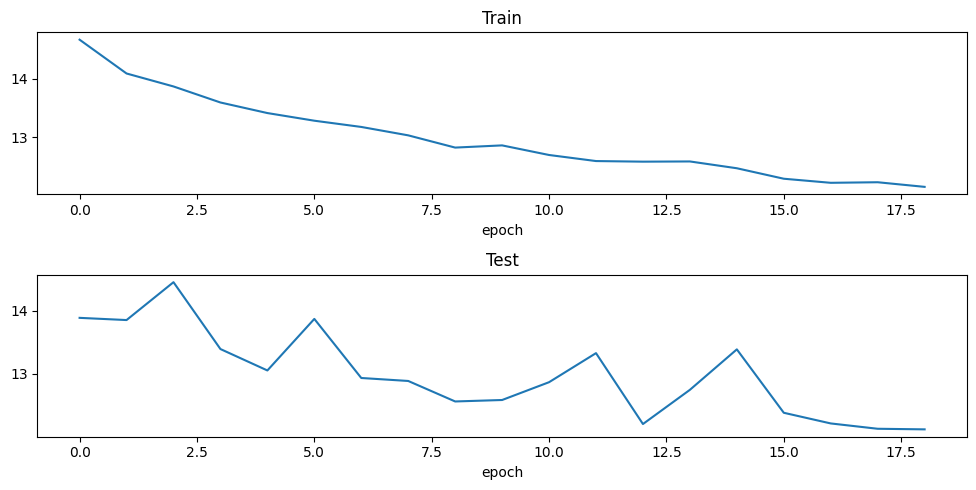

In [59]:
training_features_all = [
    "njets", "npv",
    "pt_1", "eta_1", "phi_1", "m_1", "iso_1", "q_1",
    "mt_1",
    "pt_2", "eta_2", "phi_2", "m_2", "iso_2", "q_2",
    "mt_2",
    "dm_2",
    "jpt_1", "jeta_1", "jphi_1", "jm_1", "jbtag_1",
    "jpt_2", "jeta_2", "jphi_2", "jm_2", "jbtag_2",
    "pt_met", "phi_met", "m_vis", "pt_vis",
]

net4 = Net(len(training_features_all), 64)  # net mida treenitakse kauem

all_datasets = prepare_datasets(training_features_all)
train_ds, test_ds = split_dataset(all_datasets)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=True)

loss_train_vals, loss_test_vals = train_model(net4, train_loader, test_loader, 200, 1e-4, device)   # 200 epohhi!!!
                                                                                                    # hui ka ma seda jooksutan
plot_loss(loss_train_vals, loss_test_vals)

(10.0, 15.0)

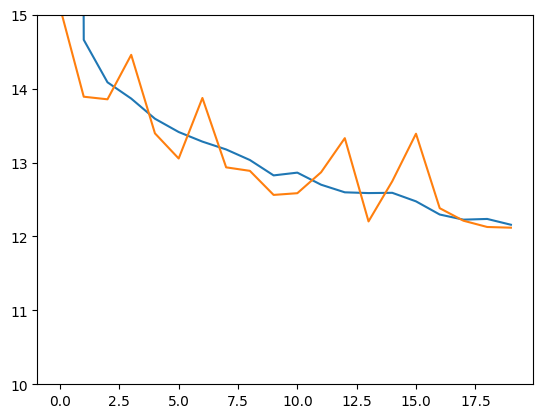

In [60]:
plt.plot(loss_train_vals)
plt.plot(loss_test_vals)
#plt.yscale("log")
plt.ylim(10,15)

In [61]:
net4 = net4.to(device="cpu")
for dataset_name in data.keys():
    data[dataset_name]["mva_4_trained"] = evaluate_net(data[dataset_name], net4, training_features_all)

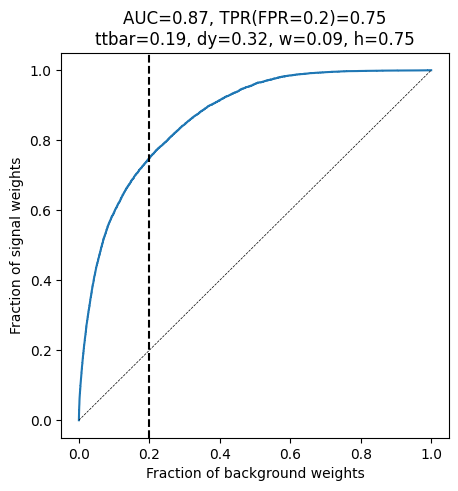

In [62]:
thresh_mva_4 = roc_curve("mva_4_trained")

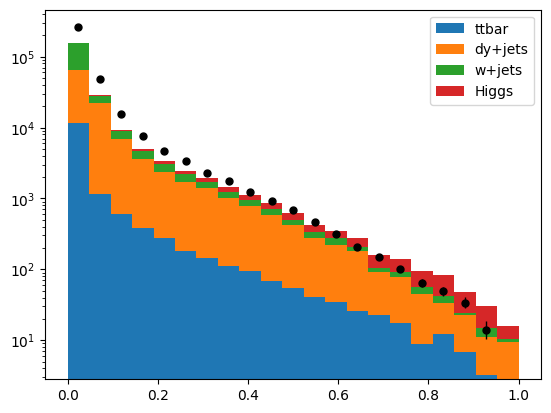

In [63]:
plot_data_mc("mva_4_trained", bh.axis.Regular(21,0.0,1.0))

## Topics for discussion

- neural net: numerical input -> numerical output, tunable parameters
    - linear transformations through matrix multiplications
    - nonlinear activations
- what is the goal or objective?
    - need to compare various methods on the same dataset
    - or the same method on various datasets
- dataset, loss function, model
- the training process is stochastic / random
    - need to be very careful about comparisons
- batch size tradeoffs
  - small batch size: low training speed, too high noise
  - large batch size: out of memory, does not converge anywhere
- missing values in case of a different number of features
- inputs on raw data
- k-folding for validation checks
- regularization: dropout, weight constraints
- multi-class classification
    - different loss functions